In [1]:
#export
"""
This includes helper clis that make it quick to graph graphviz plots."""
__all__ = ["sketch", "nodes", "edges", "Graph", "InteractiveGraph"]
import re, k1lib, math, os, numpy as np, io, json, base64, unicodedata, inspect, time, html
from k1lib.cli.init import BaseCli; import k1lib.cli as cli, k1lib.cli.init as init
graphviz = k1lib.dep.graphviz
from collections import deque, defaultdict
settings = k1lib.settings.cli
_svgAutoInc = k1lib.AutoIncrement(prefix="_k1_svg_")
_preAutoInc = k1lib.AutoIncrement(prefix="_k1_svg_pre_")
_clusterAuto = k1lib.AutoIncrement(prefix="cluster_")
_idxAuto = k1lib.AutoIncrement(prefix="_idx_")

In [2]:
#export
class sketch(BaseCli):
    _g = None; _name2Idx = None; ctxIdx = None
    def __init__(self, **kwargs):
        """Similar to :class:`~k1lib.cli.utils.sketch`, which makes it easier to plot multiple graphs quickly,
this makes it easier to plot node graphs a lot quicker than I have before. This cli
configures the graph in general, but doesn't dive too much into the specifics. Example::

    ["ab", "bc", "ca"] | (kgv.sketch(engine="sfdp") | kgv.edges())
    [["ab", "bc", "ca"], ["b", "c", "d"]] | (kgv.sketch() | kgv.edges() + kgv.nodes())

Most of the complexities are in :class:`edges`, so check that class out for more comprehensive examples

:param kwargs: keyword arguments passed into :class:`graphviz.Digraph`"""
        super().__init__(capture=True); self.kwargs = kwargs
    @staticmethod
    def _guard():
        if sketch._g is None: raise Exception("Context has not been setup yet, can't proceed to plot the edges/nodes. This could be because you're doing `data | kgv.edges()` directly. Instead, do `data | (kgv.sketch() | kgv.edges())`. The operation `kgv.sketch()` will initialize the graph")
    def __ror__(self, it):
        sketch._g = g = graphviz.Digraph(**self.kwargs); sketch._idx2Popup = idx2Popup = {}; sketch._idx2Onclick = idx2Onclick = {}
        sketch._name2Idx = name2Idx = defaultdict(lambda: defaultdict(lambda: _idxAuto()))
        sketch._nodes = nodes = []; sketch._edges = edges = []; it | self.capturedSerial | cli.deref()
        sketch._g = None; sketch._idx2Popup = None; sketch._idx2Onclick = None; sketch._name2Idx = None; sketch._nodes = None; sketch._edges = None
        return Graph(g, name2Idx, idx2Popup, idx2Onclick, nodes, edges, self.kwargs)
    def _jsF(self, meta):
        fIdx = init._jsFAuto(); dataIdx = init._jsDAuto(); ctxIdx = init._jsDAuto(); sketch.ctxIdx = ctxIdx
        header, _fIdx, _async = k1lib.kast.asyncGuard(self.capturedSerial._jsF(meta))
        res = f"""\
{ctxIdx} = null;\n{header}
{fIdx} = async ({dataIdx}) => {{
    {ctxIdx} = [];
    const out = {'await ' if _async else ''}{_fIdx}({dataIdx});

    const res = (await (await fetch("https://local.mlexps.com/routeServer/kapi_10-graphviz", {{
      method: "POST",
      body: JSON.stringify({{ "obj": {ctxIdx}, "sketchKw": {json.dumps(self.kwargs)} }}),
      headers: {{ "Content-Type": "application/json" }}
    }})).json());
    if (!res.success) throw new Error(res.reason);
    return atob(res.data);
}}""", fIdx
        sketch.ctxIdx = None; return res

In [3]:
#export
class nodes(BaseCli):
    def __init__(self, postProcessF=None):
        """Plots out nodes of the graph.
Example::

    ["a", "b"]             | kgv.nodes() # creates nodes with labels "a" and "b"
    [["s", "a"]]           | kgv.nodes() # creates node  with label "a" in subgraph with title "s"
    [["", "a"], ["", "b"]] | kgv.nodes() # creates nodes with labels "a" and "b", like the first line
    # displays popup window when user hovers over the node "a"
    [["",  "a", {"popup": "Some <b>html</b> content"}]]                      | kgv.nodes()
    # executes function when user clicks on the node "a". "nodeId" is a string that looks like "_idx_23" that uniquely identifies the node. "context" is a dict with various objects from the generated js code. Mess around with it to see what's inside
    [["",  "a", {"onclick": "(nodeId, context) => console.log('clicked')"}]] | kgv.nodes()

Each row can be multiple different lengths, but only these configurations are allowed:

- [name]
- [group, name]
- [group, name, kwargs]
- [group, name, kwargs, extraData]

See also: :class:`edges`

:param postProcessF: optional function that will be executed over the whole table (N, 4) just right before feeding into graphviz"""
        self.postProcessF = cli.aS(postProcessF or cli.iden()); self._ogPostProcessF = postProcessF
    def __ror__(self, _it) -> "``5-column input``":
        if sketch._g is None: return _it | (sketch() | self)
        sketch._guard(); it = []
        for row in _it:
            n = len(row)
            if n == 1: it.append(["", row[0], {}, None])
            elif n == 2: it.append([*row, {}, None])
            elif n == 3: it.append([*row, None])
            elif n == 4: it.append(row)
            else: raise Exception(f"kgv.nodes() can only accept tables from 1 to 4 columns. Detected {n} columns instead")
        sketch._nodes.append((it, self._ogPostProcessF)); it = self.postProcessF(it); g = sketch._g; name2Idx = sketch._name2Idx
        for s1,n1,kw,_ in it: # subgraph, node, kwargs
            idx = name2Idx[s1][n1]
            if "popup"   in kw: sketch._idx2Popup[idx]   = kw["popup"];   kw = dict(kw); del kw["popup"]
            if "onclick" in kw: sketch._idx2Onclick[idx] = kw["onclick"]; kw = dict(kw); del kw["onclick"]
            g.node(idx, **{"label": n1, **kw})
        return it
    def _jsF(self, meta):
        fIdx = init._jsFAuto(); dataIdx = init._jsDAuto(); ctxIdx = sketch.ctxIdx;
        if ctxIdx is None: return (sketch() | self)._jsF(meta)
        h1,f1,a1 = k1lib.kast.asyncGuard(self.postProcessF._jsF(meta))
        return f"""{h1}
{fIdx} = {'async ' if a1 else ''}({dataIdx}) => {{
    let it = [];
    for (const row of {dataIdx}) {{
        const n = row.length;
        if (n === 1) it.push(["", row[0], {{}}, null]);
        else if (n === 2) it.push([...row, {{}}, null]);
        else if (n === 3) it.push([...row, null]);
        else if (n === 4) it.push(row);
        else throw new Error(`kgv.nodes() can only accept tables from 1 to 4 columns. Detected ${{n}} columns instead`)
    }}
    it = {'await ' if a1 else ''}{f1}(it);
    {ctxIdx}.push(["nodes", {{it, args: []}}]); return it;
}}
""", fIdx

In [4]:
#export
def drawSimple(g, names, data, name2Idx): # data here is List[[name1, name2, kw]], names is List[name]
    for name in set(names): g.node(name2Idx[name], name);
    for name1, name2, kw in data: g.edge(name2Idx[name1], name2Idx[name2], **kw)
class edges(BaseCli):
    blurb="Plots out edges of the graph"
    def __init__(self, postProcessF=None):
        """Plots out edges of the graph.
Example 1::

    ["ab", "bc", "ca"] | kgv.edges()

Result:

.. image:: ../images/kgv_edges_1.png

If you need to customize the graph on initialization, then you can use :class:`sketch` to
capture related operations (like :class:`edges`), and inject your params in :class:`sketch`::

    ["ab", "bc", "ca"] | (kgv.sketch(engine="sfdp") | kgv.edges())

Example 2::

    [["a", "b", {"label": "3%"}], ["b", "c", {"color": "red"}], "ac", "cb"] | kgv.edges()

Result:

.. image:: ../images/kgv_edges_2.png

Example 3::

    [["group1", "a", "group1", "b", {"label": "3%"}],
     "ec",
     ["group1", "b", "", "c", {"color": "red"}],
     ["group1", "a", "", "c"],
     ["", "c", "group1", "b"],
     ["", "c", "group2", "d", {"color": "green"}]
    ] | kgv.edges()

Result:

.. image:: ../images/kgv_edges_3.png

So the idea is, each row describes a single edge on the graph. Each row
can be multiple different lengths, but only these configurations are allowed:

- [name1, name2]
- [name1, name2, kwargs]
- [group1, name1, group2, name2]
- [group1, name1, group2, name2, kwargs]
- [group1, name1, group2, name2, kwargs, extraData]

So if you don't need the complexity and just want to plot something out, you
can just use the one at the top, but if you do want fancy features, then you
can add those in the kwargs. The "extraData" is not used to graph at all, but
is there so that you can put any random data there, potentially to be used to
tweak the edges downstream by the postProcessF function. If there are multiple
post process functions defined by multiple calls to :class:`edges`, then they
will all be executed one after another, serially.

See also: :class:`nodes`, :class:`sketch`.

Check out a gallery of more examples at `kapi/10-graphviz <https://mlexps.com/kapi/10-graphviz/>`_.

:param postProcessF: optional function that will be executed over the whole table (N, 6) just right before feeding into graphviz"""
        self.postProcessF = cli.aS(postProcessF or cli.iden()); self._ogPostProcessF = postProcessF
    def __ror__(self, _it) -> "``5-column input``":
        if sketch._g is None: return _it | (sketch() | self)
        sketch._guard(); it = []
        for row in _it:
            n = len(row)
            if n == 2: it.append(["", row[0], "", row[1], {}, None])
            elif n == 3: it.append(["", row[0], "", row[1], row[2], None])
            elif n == 4: it.append([*row, {}, None])
            elif n == 5: it.append([*row, None])
            elif n == 6: it.append(row)
            else: raise Exception(f"kgv.edges() can only accept tables from 2 to 6 columns. Detected {n} columns instead")
        sketch._edges.append((it, self._ogPostProcessF)); it = self.postProcessF(it); g = sketch._g; name2Idx = sketch._name2Idx
        # grouping by segments and drawing their internals first
        for segN, names in it | (cli.batched(2) | cli.head(2)).all() | cli.joinSt() | cli.groupBy(0, True) | cli.apply(cli.joinSt(), 1) | cli.deref():
            if segN:
                with g.subgraph(name=_clusterAuto()) as subG:
                    subG.attr(label=f"{segN}"); drawSimple(subG, names, it | cli.filt(cli.op() == segN, [0, 2]) | cli.cut(1, 3, 4) | cli.deref(), name2Idx[segN])
            else: drawSimple(g, names, it | cli.filt(cli.op() == segN, [0, 2]) | cli.cut(1, 3, 4) | cli.deref(), name2Idx[""])
        # then draw external edges
        for s1, n1, s2, n2, kw, _ in it | cli.filt(lambda x: x[0] != x[2]): g.edge(name2Idx[s1][n1], name2Idx[s2][n2], **kw)
        return it
    def _jsF(self, meta):
        fIdx = init._jsFAuto(); dataIdx = init._jsDAuto(); ctxIdx = sketch.ctxIdx;
        if ctxIdx is None: return (sketch() | self)._jsF(meta)
        h1,f1,a1 = k1lib.kast.asyncGuard(self.postProcessF._jsF(meta))
        return f"""{h1}
{fIdx} = {'async ' if a1 else ''}({dataIdx}) => {{
    // why not just pass dataIdx in directly? Well, in Python, the interface is that __ror__ should return a 6-column input, so here, gotta honor that, in case the user has some operation downstream of this
    let it = [];
    for (const row of {dataIdx}) {{
        const n = row.length;
        if (n === 2) it.push(["", row[0], "", row[1], {{}}, null]);
        else if (n === 3) it.push(["", row[0], "", row[1], row[2], null]);
        else if (n === 4) it.push([...row, {{}}, null]);
        else if (n === 5) it.push([...row, null]);
        else if (n === 6) it.push(row);
        else throw new Error(`kgv.edges() can only accept tables from 2 to 6 columns. Detected ${{n}} columns instead`)
    }}
    it = {'await ' if a1 else ''}{f1}(it);
    {ctxIdx}.push(["edges", {{it, args: []}}]); return it;
}}
""", fIdx

In [23]:
#export
def _replaceIds(s) -> "[nodeIds, edgeIds, graphIds]":
    s = s.replace("><", ">\n<"); parts = s.split("\n")
    # these ids are: List[(auto generated id, unique id we're replacing it with)]:
    # - Auto generated id is generated by graphviz, looks like "node1", "node2", "edge1", "edge2"
    # - Unique id is generated by _idxAuto() for nodes, or _svgAutoInc() for edges and subgraphs
    # replacing them so that we have control over the ids and so that they don't collide with other "node1" from other graphs
    nodeIds = parts  | cli.grep('class="node"', after=1) | cli.batched(2) | cli.apply(cli.op().split("title>")[1].strip("</"), 1) | cli.grep('<g id="(?P<g>node[0-9]+)', col=0, extract="g") | cli.deref()
    edgeIds = parts  | cli.grep('<g id="(?P<g>edge[0-9]+)"', extract="g") | cli.apply(lambda x: [x, _svgAutoInc()]) | cli.deref()
    graphIds = parts | cli.grep('<g id="(?P<g>graph[0-9]+)"', extract="g") | cli.apply(lambda x: [x, _svgAutoInc()]) | cli.deref()
    for x, y in [nodeIds, edgeIds, graphIds] | cli.joinSt(): s = s.replace(f'id="{x}"', f'id="{y}"')
    # removes all <titles>, cause we've already extracted the modified ids, and titles show up as a tooltip, which is annoying
    s = re.sub(r'<title>.*?</title>', '', s, flags=re.DOTALL)
    return s, nodeIds, edgeIds, graphIds
class Graph:
    def __init__(self, g, name2Idx, idx2Popup, idx2Onclick, nodes, edges, sketchKw):
        """Wrapper around a :class:`graphviz.Graph` or :class:`graphviz.Digraph`. Internal graph
object is available at ``self.g``. Not instantiated by end user, instead, this is
returned by :class:`sketch`.

This class's whole purpose is to implement a popup window for the nodes that require it. It
analyzes the svg output of graphviz and compiles it to a form that is slightly interactive.
This is the feedstock for more complex Graphs

Also, "nodes" and "edges" contain all necessary information to reconstruct everything else like this::

    g = [...] | kgv.edges()
    [g.edges, g.nodes] | (kgv.sketch() | kgv.edges() + kgv.nodes()) # regenerated graph

You can do some extra filtering by adding a post process function to :class:`edges` and :class:`nodes`.

:param name2Idx: looks like {'': {'c': '_idx_233', 'e': '_idx_234'}}
:param idx2Popup: looks like {'_idx_113': 'some content'}. The content can be any complex html
:param idx2Onclick: looks like {'_idx_113': '(nodeId) => console.log("something")'}. The string will be eval-ed when the node is clicked
:param nodes: List[nodes, postProcessF], (cut(0) | joinSt()) is a bunch of edges, can be piped into nodes() again
:param edges: List[edges, postProcessF], (cut(0) | joinSt()) is a bunch of edges, can be piped into edges() again"""
        self.g = g; self.name2Idx = name2Idx; self.idx2Popup = idx2Popup; self.idx2Onclick = idx2Onclick
        self.nodes = list([x[0] for x in nodes] | cli.joinSt()); self.nodesPostProcessF = cli.serial(*[cli.aS(x[1]) for x in nodes if x[1]])
        self.edges = list([x[0] for x in edges] | cli.joinSt()); self.edgesPostProcessF = cli.serial(*[cli.aS(x[1]) for x in edges if x[1]])
        self.startTime = round(time.time()*1000); self.sketchKw = sketchKw
    def focus(self, name, depth=1) -> "InteractiveGraph":
        """Creates a complex interactive graph that users can click on a node to zoom in to its
surroundings. Example::

    g = ["ab", "bc", "ca", "cd"] | kgv.edges()
    g.focus("a")

:param name: name of the node, like "a" or "subgraph1\\ue002b". The second example is just the subgraph
    name and node name joined together by "\\ue002"
:param depth: all nodes <= depth away from the selected node will be displayed
:param nodeF: function to run on all nodes after filtering out-of-focus nodes
:param edgeF: function to run on all edges after filtering out-of-focus nodes"""
        return InteractiveGraph(self.nodes, self.edges, self.sketchKw, name, depth, self.nodesPostProcessF, self.edgesPostProcessF)
    def _repr_mimebundle_(self, *args, **kwargs): return self.g._repr_mimebundle_(*args, **kwargs)
    def _repr_html_(self): return self._toHtml()
    def _toImg(self, **kw): return self.g | cli.toImg()
    def _toHtml(self):
        idx2Popup = self.idx2Popup; s, nodeIds, edgeIds, graphIds = _replaceIds(self.g | cli.toHtml())
        a = [[x,list(y.items())] for x,y in self.name2Idx.items()] | cli.ungroup(False) | ~cli.apply(lambda x,y,z: [z, f"{x}\ue002{y}"]) | cli.aS(list)
        idx2Name = a | cli.toDict(); name2Idx = a | cli.cut(1, 0) | cli.toDict() # this name2Idx maps from "a\ue002b" to "_idx_233", different from self.name2Idx. I kinda just want a flat structure!
        a = nodeIds | cli.cut(1) | cli.apply(lambda idx: f"[{json.dumps(idx)}, {html.b64escape(idx2Popup.get(idx, None)) if idx2Popup.get(idx, None) else 'null'}]") | cli.join(", "); pre = f"{_preAutoInc()}_{self.startTime}"
        b = ", ".join([f"['{x}', {y}]" for x,y in self.idx2Onclick.items()])
        inside = f"rect.x <= {pre}_mouseX && {pre}_mouseX < rect.x+rect.width && rect.y <= {pre}_mouseY && {pre}_mouseY < rect.y+rect.height"
        return f"""
<div id="{pre}_wrapper" style="position: relative">{s}<div id="{pre}_popup" style="position: absolute; display: none; background: white; padding: 8px 12px; border-radius: 6px; box-shadow: 0 3px 5px rgb(0 0 0 / 0.3); z-index: 1000000"></div></div>
<script>
    {pre}_idx2Name = {json.dumps(idx2Name)}; {pre}_name2Idx = {json.dumps(name2Idx)};
    {pre}_nodeId_node_popup = ([{a}]).map(([x,y]) => [x, document.querySelector(`#${{x}}`), y]);
    {pre}_nodeId_node_onclick = ([{b}]).map(([x,y]) => [x, document.querySelector(`#${{x}}`), y]);
    {pre}_nodes = {pre}_nodeId_node_popup.map(([x,n,y]) => n); {pre}_activeNode = null;
    {pre}_popup = document.querySelector("#{pre}_popup"); {pre}_wrapper = document.querySelector("#{pre}_wrapper");
    {pre}_nodeId2Popup = {{}}; for (const [x,n,y] of {pre}_nodeId_node_popup) {{ {pre}_nodeId2Popup[x] = y; }};
    {pre}_context = {{nodeId_node_popup: {pre}_nodeId_node_popup, nodeId_node_onclick: {pre}_nodeId_node_onclick, nodes: {pre}_nodes, idx2Name: {pre}_idx2Name, name2Idx: {pre}_name2Idx}};
    {pre}_mouseX = 0; {pre}_mouseY = 0; {pre}_wrapper.onmousemove = (e) => {{ {pre}_mouseX = e.clientX; {pre}_mouseY = e.clientY; }};
    {pre}_adjustInterval = null;
    {pre}_wrapper.onclick = (e) => {{
        const wRect = {pre}_wrapper.getBoundingClientRect();
        for (const [nodeId, node, f] of {pre}_nodeId_node_onclick) {{
            const rect = node.getBoundingClientRect();
            if ({inside}) {{ f({pre}_idx2Name[nodeId], {pre}_context); break; }}
        }}
    }};

    setInterval(() => {{
        if ({pre}_activeNode) {{
            const rect = {pre}_activeNode.getBoundingClientRect();
            if (!({inside})) {{ clearInterval({pre}_adjustInterval); {pre}_adjustInterval = null; {pre}_activeNode = null; {pre}_popup.innerHTML = ""; {pre}_popup.style.display = "none"; }}
        }}

        if (!{pre}_activeNode) {{ // can't just do `if (activeNode) ... else ...` btw. Separated out for a reason
            const wRect = {pre}_wrapper.getBoundingClientRect();
            for (const node of {pre}_nodes) {{
                const rect = node.getBoundingClientRect();
                if ({inside}) {{
                    const popup = {pre}_nodeId2Popup[node.id];
                    {pre}_activeNode = node;
                    if (popup) {{
                        {pre}_popup.style.left = rect.x + rect.width/2 + 10 - wRect.x + "px";
                        {pre}_popup.style.top = 0; {pre}_popup.innerHTML = popup; {pre}_popup.style.display = "block";
                        (async () => {{ // popup might have <script> tags, so let's execute all of them
                            await (new Promise(r => setTimeout(r, 30)));
                            try {{ for (const script of {pre}_popup.getElementsByTagName("script")) eval(script.innerHTML);
                            }} catch (e) {{ {pre}_popup.innerHTML = `<pre style="color: red">Error encountered:\n${{e}}</pre>`; }}
                        }})();
                        if ({pre}_adjustInterval) clearInterval({pre}_adjustInterval);
                        const adjustF = () => {{
                            if ({pre}_activeNode) {{
                                const pRect = {pre}_popup.getBoundingClientRect();
                                const t1 = rect.y + rect.height/2 + 10 - wRect.y; // "t" for "top"
                                const t2 = wRect.height - pRect.height;
                                {pre}_popup.style.top = ((t2 < 0) ? 0 : Math.min(t1, t2)) + "px";
                            }}
                        }}; adjustF();
                        {pre}_adjustInterval = setInterval(adjustF, 100);
                    }}
                    break;
                }}
            }}
        }}
    }}, 30);
    console.log("k1.Graph '{pre}' loaded");
</script>"""
        return s

In [24]:
#export
def _nodeJsonDump2(nodes): # overrides json.dumps(), just because I want to expose the function directly, instead of eval-ing it
    ans = []
    for name, kw in nodes:
        skw = [f"{json.dumps(k)}: {json.dumps(v)}" for k,v in kw.items() if k != "onclick"]
        if "onclick" in kw: skw.append(f"'onclick': {kw['onclick']}")
        skw = "{" + ", ".join(skw) + "}"; ans.append(f"[{json.dumps(name)}, {skw}]")
    return "[" + ", ".join(ans) + "]"

In [25]:
assert _nodeJsonDump2([["a", {}], ["b", {"popup": "pop content"}], ["c", {"onclick": "() => alert('something')"}]]) == '[["a", {}], ["b", {"popup": "pop content"}], ["c", {\'onclick\': () => alert(\'something\')}]]'

In [26]:
#export
class InteractiveGraph:
    def __init__(self, nodes, edges, sketchKw, focus:str, depth:int=1, nodeF=None, edgeF=None): # same signature as Graph
        self.nodes = nodes; self.edges = edges; self.sketchKw = sketchKw; self.focus = focus if "\ue002" in focus else f"\ue002{focus}"; self.depth = depth
        # refining the nodes and edges (turn [s1, n1] pairs into "s1\ue002n1")
        self.rEdges = [[f"{s1}\ue002{n1}", f"{s2}\ue002{n2}", kw, extras] for s1,n1,s2,n2,kw,extras in edges]
        self.rNodes = [[f"{s}\ue002{n}", kw, extras] for s,n,kw,extras in nodes]; self.startTime = round(time.time()*1000)
        self.nodeF = cli.aS(nodeF or cli.iden()); self.edgeF = cli.aS(edgeF or cli.iden()); allNodeNames = self.rEdges | cli.cut(0, 1) | cli.joinSt() | cli.aS(set)
        for name in allNodeNames - set(self.rNodes | cli.cut(0)): self.rNodes.append([name, {}, None]) # add node entries so that I can override the onclick field, to inject in the InteractiveGraph's callback
    def _repr_html_(self): return self._toHtml()
    def _toHtml(self):
        pre = f"{_preAutoInc()}_{self.startTime}"; nodes = [[name, {**kw, "onclick": f"{pre}_ocb"}, extras] for name, kw, extras in self.rNodes]
        name2Idx = self.rNodes | cli.cut(0) | cli.insId(begin=False) | cli.toDict()
        inside = f"rect.x <= {pre}_mouseX && {pre}_mouseX < rect.x+rect.width && rect.y <= {pre}_mouseY && {pre}_mouseY < rect.y+rect.height"
        h1,f1,a1 = k1lib.kast.asyncGuard(self.nodeF._jsF({})); h2,f2,a2 = k1lib.kast.asyncGuard(self.edgeF._jsF({}))
        return f"""
<button id="{pre}_homeBtn" style="padding: 4px 6px">Home</button><span style="margin-left: 8px">Focused on: </span><span id="{pre}_focusedOn">nothing</span>. <span style="margin-left: 6px">Click on any node to focus on it. Click home to view all nodes (might be big!)</span>
<div id="{pre}_loading"></div>
<div id="{pre}_wrapper" style="margin-top: 8px">(Rendering...)</div>
<script>
    {h1}\n{h2}
    {pre}_nodes = {json.dumps(nodes)}; {pre}_edges = {json.dumps(self.rEdges)};
    {pre}_sNodes = null; {pre}_sEdges = null; // selected nodes and edges to be rendered
    {pre}_name2Idx = {json.dumps(name2Idx)}; {pre}_wrapper = document.querySelector("#{pre}_wrapper"); {pre}_loading = document.querySelector("#{pre}_loading");
    {pre}_focusedOn = document.querySelector("#{pre}_focusedOn");
    async function {pre}_render() {{ // renders sNodes and sEdges using mlexps's demo, then inject into wrapper
        const nodes = {'await ' if a1 else ''}{f1}({pre}_nodes.map(([name, kw,extras], i) => [...name.split("\ue002"), kw, extras]).filter((e, i) => {pre}_sNodes[i]));
        const edges = {'await ' if a2 else ''}{f2}({pre}_edges.map(([n1,n2,kw,extras], i) => [...n1.split("\ue002"), ...n2.split("\ue002"), kw, extras]).filter((e, i) => {pre}_sEdges[i]));
        
        {pre}_loading.innerHTML = "Loading...";
        const res = (await (await fetch("https://local.mlexps.com/routeServer/kapi_10-graphviz", {{
          method: "POST",
          body: JSON.stringify({{ 'obj': [["edges", {{"it": edges}}], ["nodes", {{"it": nodes}}]], 'sketchKw': {json.dumps(self.sketchKw)} }}),
          headers: {{ "Content-Type": "application/json" }}
        }})).json()).data;
        {pre}_wrapper.innerHTML = atob(res);
        (async () => {{
            await (new Promise(r => setTimeout(r, 100)));
            try {{
                for (const script of {pre}_wrapper.getElementsByTagName("script")) eval(script.innerHTML);
                {pre}_loading.innerHTML = "";
            }} catch (e) {{ {pre}_loading.innerHTML = `<pre style="color: red">Error encountered:\n${{e}}</pre>`; }}
        }})();
    }}
    function {pre}_reset() {{
        {pre}_sNodes = [...new Array({len(nodes)}      ).keys()].map((x) => 1);
        {pre}_sEdges = [...new Array({len(self.rEdges)}).keys()].map((x) => 1);
    }}; {pre}_reset();
    function {pre}_home() {{
        {pre}_focusedOn.innerHTML = "nothing";
        {pre}_sNodes = [...new Array({len(nodes)}      ).keys()].map((x) => 1);
        {pre}_sEdges = [...new Array({len(self.rEdges)}).keys()].map((x) => 1);
        {pre}_render();
    }}; setTimeout(() => {pre}_ocb({json.dumps(self.focus)}), 300);
    document.querySelector("#{pre}_homeBtn").onclick = {pre}_home;
    function {pre}_ocb(name, ctx) {{ // callback to inject into all. Forms sNodes and sEdges from nodes and edges
        {pre}_focusedOn.innerHTML = name.replace("\ue002", ">");
        const depth = {self.depth};
        let sNodes = new Set([name]); // set of node names that will be selected to display out
        for (let i = 0; i < depth; i++) {{
            let newOnes = [];
            for (const [n1,n2,kw] of {pre}_edges) {{
                if (sNodes.includes(n1)) newOnes.push(n2);
                if (sNodes.includes(n2)) newOnes.push(n1);
            }}
            for (const e of newOnes) sNodes.add(e);
        }}
        {pre}_sEdges = {pre}_edges.map(([n1,n2,kw]) => sNodes.includes(n1) && sNodes.includes(n2));
        {pre}_sNodes = {pre}_nodes.map(([n,kw]) => sNodes.includes(n));
        {pre}_render();
    }}
</script>"""

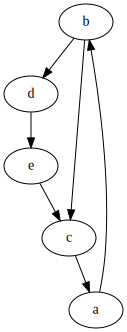

In [29]:
g = [["ab", "bc", "ca", "bd", "de", "ec"], [["", "a", {"popup": "pop content"}]]] | (sketch() | edges() + nodes()); g

In [82]:
["ab", "bc", "ca"] | edges() | cli.toImg() | cli.file("../../docs/images/kgv_edges_1.png")
[["a", "b", {"label": "3%"}], ["b", "c", {"color": "red"}], "ac", "cb"] | edges() | cli.toImg() | cli.file("../../docs/images/kgv_edges_2.png")
[["group1", "a", "group1", "b", {"label": "3%"}], "ec", ["group1", "b", "", "c", {"color": "red"}], ["group1", "a", "", "c"], ["", "c", "group1", "b"], ["", "c", "group2", "d", {"color": "green"}]] | edges() | cli.toImg() | cli.file("../../docs/images/kgv_edges_3.png")

'../../docs/images/kgv_edges_3.png'

In [20]:
g = [["ab", "bc", "ca", "bd", "de", "ec"], [["", "a", {"popup": "pop content"}]]] | (sketch() | edges() + nodes())
g.focus("a")#._toHtml().split("\n")

In [31]:
!../../export.py cli/kgv --upload=True

2024-02-28 13:39:35,750	INFO worker.py:1458 -- Connecting to existing Ray cluster at address: 192.168.1.19:6379...
2024-02-28 13:39:35,757	INFO worker.py:1633 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
./export started up - /home/kelvin/anaconda3/envs/ray2/bin/python3
----- exportAll
15088   0   61%   
9735    1   39%   
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 1.5.2
Uninstalling k1lib-1.5.2:
  Successfully uninstalled k1lib-1.5.2
running install
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdi

In [48]:
!../../export.py cli/kgv

2024-03-16 18:11:05,743	INFO worker.py:1458 -- Connecting to existing Ray cluster at address: 192.168.1.17:6379...
2024-03-16 18:11:05,753	INFO worker.py:1633 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
./export started up - /home/kelvin/anaconda3/envs/ray2/bin/python3
----- exportAll
15713   0   61%   
10075   1   39%   
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 1.6.2
Uninstalling k1lib-1.6.2:
  Successfully uninstalled k1lib-1.6.2
running install
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdi

In [34]:
!../../export.py cli/kgv --boostrap=True

2024-03-05 17:40:33,094	INFO worker.py:1458 -- Connecting to existing Ray cluster at address: 192.168.1.17:6379...
2024-03-05 17:40:33,101	INFO worker.py:1633 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
./export started up - /home/kelvin/anaconda3/envs/ray2/bin/python3
----- exportAll
15428   0   61%   
9958    1   39%   
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 1.5.2
Uninstalling k1lib-1.5.2:
  Successfully uninstalled k1lib-1.5.2
running install
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdi